In [1]:
import nltk
nltk.download('punkt')

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model
import plotly.express as px
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df_fake = pd.read_csv("Fake.csv")
df_true = pd.read_csv("True.csv")

df_fake = df_fake[9052:15891]
df_true = df_true[:11272]

df_true['isfake'] = 0
df_fake['isfake'] = 1

df = pd.concat([df_true, df_fake]).reset_index(drop=True)

df.drop(columns=['date'], inplace=True)

# combine title and text together
df['original'] = df['title'] + ' ' + df['text']
df_true.tail()

In [19]:
df['original'][18000]

'WATCH YOUNG TEENAGE THUGS AS THEY ROB FEMALE REPORTER Filming #BaltimoreRiots Because nothing says  justice  for Freddie Gray like a large group of teenage thugs descending on a defenseless woman and stealing her purse A producer for Ruptly, a video news service run by RT (formerly Russia Today), was robbed on camera while filming the violent protests in Baltimore overnight.The dramatic video shows the female victim first surrounded and harassed by a group of youths, who rapidly grow bolder reaching out at her, all the while hurling a stream of vulgarity and ranting about the police. She is then clearly physically attacked by the group. As the video stabilizes you see that the producer is chasing the thieves down the street trying to retrieve her stolen bag before the intervention of the Baltimore police.The protests in Baltimore over the death of Freddie Gray while in custody turned into violent riots overnight Saturday into Sunday morning. So much so that 30,000 people were locked d

In [3]:
# Standardize text data
# def removeCharacter(row):
#     # xoa dau cham, phay, hoi o cuoi cau.
#     row = re.sub(r"[\.,\?]+$", "", row)
#     row = row.replace(",", " ").replace(".", " ")\
#         .replace(";", " ").replace("“", " ")\
#         .replace(":", " ").replace("”", " ")\
#         .replace('"', " ").replace("'", " ")\
#         .replace("!", " ").replace("?", " ")\
#         .replace(">", " ").replace("<", " ")\
#         .replace(")", " ").replace("(", " ")\
#         .replace("-", " ").replace("+", " ")
#     return row.strip()
def toLowerCase(row):
    row = row.lower()
    return row

def removeLinkSpam(row):
    row = re.sub(r'http[s]?://\S+', '', row)
    return row

# read_file = pd.read_csv (r'teencode.csv')
# codes = list(read_file.codes)
# means = list(read_file.means)
# def standaCacTuVietTat(row):
#     stri = ("|".join(codes))
#     lis = set(re.findall(stri, row))
#     rows = set(row.split())
#     lis = list(lis.intersection(rows))
#     for i in lis:
#         index = codes.index(i)
#         val = means[index]
#         row = re.sub(rf"{i}", val, row)
#     return row

nltk.download("stopwords")
# Obtain additional stopwords from nltk
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
# Remove stopwords and remove words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)

    return result

def pre_process(row):
    row = removeLinkSpam(row)
    
    row = toLowerCase(row)
    
    row = preprocess(row)

    return row


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Apply the function to the dataframe
df['clean'] = df['original'].apply(pre_process)

list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)

total_words = len(list(set(list_of_words)))

# join the words into a string
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))
df['clean_joined'][11111]

In [5]:
# length of maximum document will be needed to create word embeddings
maxlen = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if maxlen < len(tokens):
      maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 4405


In [6]:
# split data into test and train
x_train, x_test, y_train, y_test = train_test_split(
    df.clean_joined, df.isfake, test_size=0.3)

In [7]:
print(total_words)

60301


In [13]:
# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words=total_words)
tokenizer.fit_on_texts(x_train)
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
print(tokenizer.word_index)
print(tokenizer.word_docs)
print(tokenizer.word_counts)
print(len(tokenizer.word_index))

In [9]:
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

In [ ]:
print(x_train[1], "\n\t", train_sequences[1])
print(len(x_train[1].split()), '\t' , len(train_sequences[1]))

military accept transgender recruits monday pentagon washington reuters transgender people allowed time enlist military starting monday ordered federal courts pentagon said friday president donald trump administration decided appeal rulings blocked transgender federal appeals courts washington virginia week rejected administration request hold orders lower court judges requiring military begin accepting transgender recruits justice department official said administration challenge rulings department defense announced releasing independent study issues coming weeks litigate interim appeal occurs administration decided wait study continue defend president lawful authority district court meantime official said speaking condition anonymity september pentagon said created panel senior officials study implement directive trump prohibit transgender individuals serving defense department submit plan trump lawyers representing currently serving transgender service members aspiring recruits said

In [10]:
max = -1
for i in train_sequences:
  if len(i) >= max:
    max = len(i)
print(max)
max = -1
for i in test_sequences:
  if len(i) >= max:
    max = len(i)
print(max)

4186
4403


In [11]:
# Add padding can either be maxlen = 4406 or smaller number maxlen = 40 seems to work well based on results
padded_train = pad_sequences(train_sequences,maxlen=256, padding='post', truncating='post')
padded_test = pad_sequences(test_sequences,maxlen=256, padding='post', truncating='post')

for i, doc in enumerate(padded_train[:4]):
    print("The padded encoding for document", i, " is : ", doc)

print(padded_train.shape)

The padded encoding for document 0  is :  [ 2744   990   243  5857 27497   208   379   136  2873  4144   325   136
  1620   208  1666   935  6702 12190  1700  1700  2905  1071    50  1072
   709   803 34080 19462 11097    53   978  7044    63    99  2538   333
  5857 23811   712   990  1608   243  2744   840  5858    20    53   476
   588   551  2007   202   512   840   290  2262  8674   712   935   779
   338   512   722   840  2007  1004  3164   886   712   829  1097   127
     2   136  1520 14417  1620   712    50  1072  5405   146  4762 14417
  1985  2347    20    28  1304  2048  6702 12190  1700  1700  2905  1071
    50  1072   709 14417  5406     1    21  3023  1796   208   252   713
  1620     7    21 27498   982   448  1666    20   476   588  1912   156
   136     2  1851  1872   208   252   935   779    53   526   338  6703
   935  1624   526 14417  2292   275   992   748   868   424   208   252
  1207  8317   331  1075    46   602   994   476   588  1087    31   696
    39   

# **without pad_sequences**

In [ ]:
# Sequential Model
model = Sequential()
# embeddidng layer
model.add(Embedding(total_words, output_dim = 128))
# LSTM
model.add(LSTM(64))
# Dense layers
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

y_train = np.asarray(y_train)
# train the model
trained = model.fit(train_sequences, y_train, batch_size=32, validation_split=0.2, epochs=4)
# make prediction
pred = model.predict(test_sequences)
# if the predicted value is > 0.95 it is real else it is fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.95:
        prediction.append(1)
    else:
        prediction.append(0)
# getting the accuracy
accuracy = accuracy_score(list(y_test), prediction)
print("Model Accuracy : ", accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         7718656   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 7,770,177
Trainable params: 7,770,177
Non-trainable params: 0
_________________________________________________________________



KeyboardInterrupt



# **batsize=32, epochs=[4, 5]**

In [ ]:
!pip install scikeras
from sklearn.model_selection import GridSearchCV 
from scikeras.wrappers import KerasClassifier

def create_model():
  model = Sequential()
  model.add(Embedding(total_words, output_dim = 128))
  model.add(LSTM(64))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  model.summary()
  return model

# create model
model = KerasClassifier(model=create_model, verbose=0)
# define the grid search parameters
batch_size = [32]
epochs = [4, 5]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
y_train = np.asarray(y_train)
grid_result = grid.fit(padded_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         7718656   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 7,770,177
Trainable params: 7,770,177
Non-trainable params: 0
_________________________________________________________________
Best: 0.996687 using {'batch_size': 32, 'epochs': 4}
0.996687 (0.000169) with: 

# **padded by length = 40**

In [ ]:
!pip install scikeras
from sklearn.model_selection import GridSearchCV 
from scikeras.wrappers import KerasClassifier

def create_model():
  model = Sequential()
  model.add(Embedding(total_words, output_dim = 128))
  model.add(LSTM(64))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  model.summary()
  return model

# create model
model = KerasClassifier(model=create_model, verbose=0)
# define the grid search parameters
batch_size = [32, 64, 128, 256]
epochs = [2, 3, 4, 5, 6]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
y_train = np.asarray(y_train)
grid_result = grid.fit(padded_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 128)         7718656   
                                                                 
 lstm_4 (LSTM)               (None, 64)                49408     
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 7,770,177
Trainable params: 7,770,177
Non-trainable params: 0
_________________________________________________________________
Best: 0.997446 using {'batch_size': 32, 'epochs': 4}
0.995582 (0.001562) with: {'batch_size': 32, 'epochs': 2}
0.996411 (0.000961) with: {'batch_size': 32, 'epochs': 3}
0.99744

In [ ]:
!pip install scikeras
from sklearn.model_selection import GridSearchCV 
from scikeras.wrappers import KerasClassifier

def create_model():
  model = Sequential()
  model.add(Embedding(total_words, output_dim = 128))
  model.add(LSTM(64))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  return model

# create model
model = KerasClassifier(model=create_model, loss="binary_crossentropy", epochs=4, batch_size=32, verbose=0)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(padded_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.997446 using {'optimizer': 'Adam'}
0.681323 (0.001252) with: {'optimizer': 'SGD'}
0.995376 (0.001187) with: {'optimizer': 'RMSprop'}
0.643637 (0.027803) with: {'optimizer': 'Adagrad'}
0.590145 (0.018545) with: {'optimizer': 'Adadelta'}
0.997446 (0.001019) with: {'optimizer': 'Adam'}
0.995651 (0.001782) with: {'optimizer': 'Adamax'}
0.996963 (0.000544) with: {'optimizer': 'Nadam'}


# **Try to build model with batch_size=32, epochs=4, optimizer='adam'**

In [ ]:
# Sequential Model
model = Sequential()
# embeddidng layer
model.add(Embedding(total_words, output_dim = 128))
# LSTM
model.add(LSTM(64))
# Dense layers
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

y_train = np.asarray(y_train)
# train the model
trained = model.fit(padded_train, y_train, batch_size=32, validation_split=0.2, epochs=4)
# make prediction
pred = model.predict(padded_test)
# if the predicted value is > 0.95 it is real else it is fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.95:
        prediction.append(1)
    else:
        prediction.append(0)
# getting the accuracy
accuracy = accuracy_score(list(y_test), prediction)
print("Model Accuracy : ", accuracy)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 128)         7718656   
                                                                 
 lstm_6 (LSTM)               (None, 64)                49408     
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 7,770,177
Trainable params: 7,770,177
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
363/363 [==============================] - 45s 117ms/step - loss: 0.0868 - acc: 0.9652 - val_loss: 0.0223 - val_acc: 0.9955
Epoch 2/4
363/363 [=======================

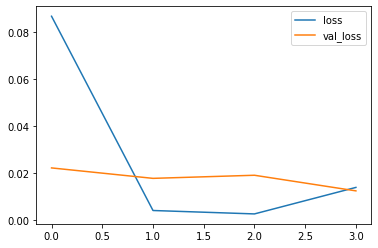

In [ ]:
import matplotlib.pyplot as plt
plt.plot(trained.history['loss'], label='loss')
plt.plot(trained.history['val_loss'], label='val_loss')
plt.legend()

In [ ]:

# Sequential Model
model = Sequential()
# embeddidng layer
model.add(Embedding(total_words, output_dim = 128))
# LSTM
model.add(LSTM(64))
# Dense layers
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

y_train = np.asarray(y_train)
# train the model
trained = model.fit(padded_train, y_train, batch_size=32, validation_split=0.2, epochs=4)
# make prediction
pred = model.predict(padded_test)
# if the predicted value is > 0.95 it is real else it is fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.95:
        prediction.append(1)
    else:
        prediction.append(0)
# getting the accuracy
accuracy = accuracy_score(list(y_test), prediction)
print("Model Accuracy : ", accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         7718656   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 7,770,177
Trainable params: 7,770,177
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
363/363 [==============================] - 100s 268ms/step - loss: 0.4546 - acc: 0.7896 - val_loss: 0.3438 - val_acc: 0.8820
Epoch 2/4
363/363 [========================

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         7718528   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 8,014,721
Trainable params: 8,014,721
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
317/317 [==============================] - 245s 723ms/step - loss: 0.0875 - acc: 0.9627 - val_loss: 0.

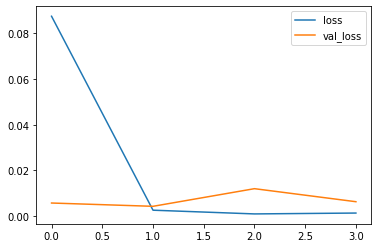

In [12]:
# Sequential Model
model = Sequential()

# embeddidng layer
model.add(Embedding(total_words, output_dim = 128))

# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()
y_train = np.asarray(y_train)
# train the model
trained=model.fit(padded_train, y_train, batch_size = 32, validation_split = 0.2, epochs = 4)
# make prediction

model.save("model.h5")

pred = model.predict(padded_test)
# if the predicted value is > 0.95 it is real else it is fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.95:
        prediction.append(1)
    else:
        prediction.append(0)
# getting the accuracy
accuracy = accuracy_score(list(y_test), prediction)
print("Model Accuracy : ", accuracy)
import matplotlib.pyplot as plt
plt.plot(trained.history['loss'], label='loss')
plt.plot(trained.history['val_loss'], label='val_loss')
plt.legend()

# **Bidirection-LSTM**

In [ ]:
!pip install scikeras
from sklearn.model_selection import GridSearchCV 
from scikeras.wrappers import KerasClassifier

def create_model():
  model = Sequential()
  model.add(Embedding(total_words, output_dim = 128))
  model.add(Bidirectional(LSTM(128)))
  model.add(Dense(128, activation = 'relu'))
  model.add(Dense(1,activation= 'sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  model.summary()
  return model

# create model
model = KerasClassifier(model=create_model, verbose=0)
# define the grid search parameters
batch_size = [32, 64, 128]
epochs = [2, 3, 4, 5, 6]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
y_train = np.asarray(y_train)
grid_result = grid.fit(padded_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         7718656   
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 8,014,849
Trainable params: 8,014,849
Non-trainable params: 0
_________________________________________________________________
Best: 0.997

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 256)         15437312  
                                                                 
 bidirectional_4 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 15,864,577
Trainable params: 15,864,577
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
363/363 [==============================] - 124s 330ms/step - loss: 0.0707 - acc: 0.9722 - val_loss

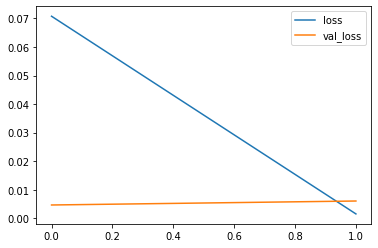

In [ ]:
# Sequential Model
model = Sequential()

# embeddidng layer
# model.add(Embedding(total_words, output_dim = 128))
model.add(Embedding(total_words, output_dim = 256))


# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()
y_train = np.asarray(y_train)
# train the model
trained=model.fit(padded_train, y_train, batch_size = 32, validation_split = 0.2, epochs = 2)
# make prediction
pred = model.predict(padded_test)
# if the predicted value is > 0.95 it is real else it is fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.95:
        prediction.append(1)
    else:
        prediction.append(0)
# getting the accuracy
accuracy = accuracy_score(list(y_test), prediction)
print("Model Accuracy : ", accuracy)
import matplotlib.pyplot as plt
plt.plot(trained.history['loss'], label='loss')
plt.plot(trained.history['val_loss'], label='val_loss')
plt.legend()

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(total_words, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])
model.summary()

y_train = np.asarray(y_train)
# train the model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
trained = model.fit(padded_train, y_train, epochs=5,validation_split=0.1, batch_size=32, shuffle=True, callbacks=[early_stop])
# make prediction
pred = model.predict(padded_test)
# if the predicted value is > 0.95 it is real else it is fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.95:
        prediction.append(1)
    else:
        prediction.append(0)
# getting the accuracy
accuracy = accuracy_score(list(y_test), prediction)
print("Model Accuracy : ", accuracy)

In [ ]:
# Sequential Model
model = Sequential()
# embeddidng layer
model.add(Embedding(input_dim = total_words, output_dim = 128))
# LSTM
model.add(LSTM(64))
# Dense layers
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

y_train = np.asarray(y_train)
# train the model
trained = model.fit(padded_train, y_train, batch_size=32, validation_split=0.2, epochs=2)
# make prediction
pred = model.predict(padded_test)
# if the predicted value is > 0.95 it is real else it is fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.95:
        prediction.append(1)
    else:
        prediction.append(0)
# getting the accuracy
accuracy = accuracy_score(list(y_test), prediction)
print("Model Accuracy : ", accuracy)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         8133632   
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 8,185,153
Trainable params: 8,185,153
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
304/304 [==============================] - 43s 133ms/step - loss: 0.1036 - acc: 0.9565 - val_loss: 0.0150 - val_acc: 0.9975
Epoch 2/2
187/187 [=======================

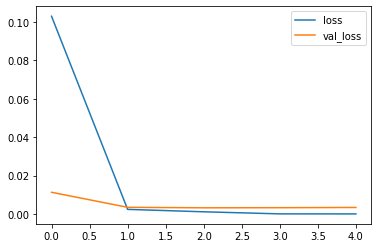

In [ ]:
import matplotlib.pyplot as plt
plt.plot(trained.history['loss'], label='loss')
plt.plot(trained.history['val_loss'], label='val_loss')
plt.legend()

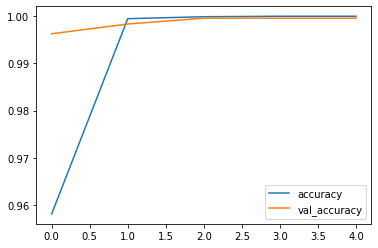

In [ ]:
import matplotlib.pyplot as plt
plt.plot(trained.history['acc'], label='accuracy')
plt.plot(trained.history['val_acc'], label='val_accuracy')
plt.legend()

In [ ]:
# Sequential Model
model1 = Sequential()
# embeddidng layer
model1.add(Embedding(total_words, output_dim=128))
# Bi-Directional RNN and LSTM
model1.add(Bidirectional(LSTM(128)))
# Dense layers
model1.add(Dense(64, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model1.summary()

y_train = np.asarray(y_train)
# train the model
trained = model1.fit(padded_train, y_train, batch_size=64, validation_split=0.1, epochs=5)
# make prediction
pred = model1.predict(padded_test)
# if the predicted value is > 0.95 it is real else it is fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.95:
        prediction.append(1)
    else:
        prediction.append(0)
# getting the accuracy
accuracy = accuracy_score(list(y_test), prediction)
print("Model Accuracy : ", accuracy)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 128)         8133632   
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 64)                16448     
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,413,313
Trainable params: 8,413,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
171/171 [==============================] - 51s 276ms/step - loss: 0.1003 - acc: 0.9547 - val_loss: 0

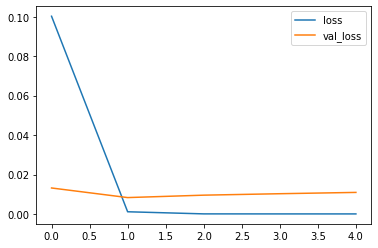

In [ ]:
import matplotlib.pyplot as plt
plt.plot(trained.history['loss'], label='loss')
plt.plot(trained.history['val_loss'], label='val_loss')
plt.legend()

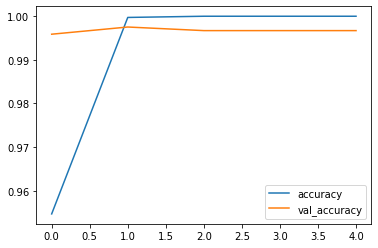

In [ ]:
import matplotlib.pyplot as plt
plt.plot(trained.history['acc'], label='accuracy')
plt.plot(trained.history['val_acc'], label='val_accuracy')
plt.legend()

In [ ]:
# Sequential Model
model2 = Sequential()
# embeddidng layer
model2.add(Embedding(total_words, output_dim=128))
# Bi-Directional RNN and LSTM
model2.add(Bidirectional(LSTM(64)))
# Dense layers
model2.add(Dense(32, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model2.summary()

y_train = np.asarray(y_train)
# train the model
trained = model2.fit(padded_train, y_train, batch_size=32, validation_split=0.1, epochs=5)
# make prediction
pred = model2.predict(padded_test)
# if the predicted value is > 0.95 it is real else it is fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.95:
        prediction.append(1)
    else:
        prediction.append(0)
# getting the accuracy
accuracy = accuracy_score(list(y_test), prediction)
print("Model Accuracy : ", accuracy)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 128)         8133632   
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 32)                4128      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 8,236,609
Trainable params: 8,236,609
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
342/342 [==============================] - 62s 136ms/step - loss: 0.0744 - acc: 0.9672 - val_loss: 0

In [ ]:
# Sequential Model
model2 = Sequential()
# embeddidng layer
model2.add(Embedding(total_words, output_dim=240))
# Bi-Directional RNN and LSTM
model2.add(Bidirectional(LSTM(240)))
# Dense layers
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model2.summary()

y_train = np.asarray(y_train)
# train the model
trained = model2.fit(padded_train, y_train, batch_size=64, validation_split=0.1, epochs=5)
# make prediction
pred = model2.predict(padded_test)
# if the predicted value is > 0.95 it is real else it is fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.95:
        prediction.append(1)
    else:
        prediction.append(0)
# getting the accuracy
accuracy = accuracy_score(list(y_test), prediction)
print("Model Accuracy : ", accuracy)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 240)         15250560  
                                                                 
 bidirectional_4 (Bidirectio  (None, 480)              923520    
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 64)                30784     
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,204,929
Trainable params: 16,204,929
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
171/171 [==============================] - 116s 656ms/step - loss: 0.0795 - acc: 0.9674 - val_loss

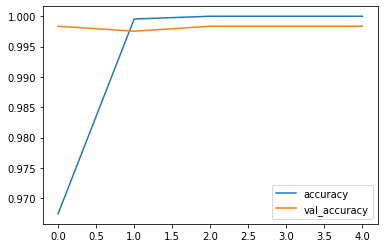

In [ ]:
import matplotlib.pyplot as plt
plt.plot(trained.history['acc'], label='accuracy')
plt.plot(trained.history['val_acc'], label='val_accuracy')
plt.legend()

In [ ]:
# Sequential Model
model = Sequential()

# Embeddidng layer
model.add(Embedding(total_words, output_dim = 240))


# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()


y_train = np.asarray(y_train)
# train the model
model.fit(padded_train, y_train, batch_size=64, validation_split=0.1, epochs=5)
# make prediction
pred = model.predict(padded_test)
# if the predicted value is > 0.95 it is real else it is fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.95:
        prediction.append(1)
    else:
        prediction.append(0)
# getting the accuracy
accuracy = accuracy_score(list(y_test), prediction)
print("Model Accuracy : ", accuracy)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 240)         19918080  
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              377856    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 20,328,961
Trainable params: 20,328,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
204/204 [==============================] - 111s 521ms/step - loss: 0.0753 - acc: 0.9642 - val_loss

In [ ]:
# Sequential Model
model = Sequential()

# Embeddidng layer
model.add(Embedding(total_words, output_dim = 240))


# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(240)))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()


y_train = np.asarray(y_train)
# train the model
model.fit(padded_train, y_train, batch_size=64, validation_split=0.1, epochs=5)
# make prediction
pred = model.predict(padded_test)
# if the predicted value is > 0.95 it is real else it is fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.95:
        prediction.append(1)
    else:
        prediction.append(0)
# getting the accuracy
accuracy = accuracy_score(list(y_test), prediction)
print("Model Accuracy : ", accuracy)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 240)         19918080  
                                                                 
 bidirectional_8 (Bidirectio  (None, 480)              923520    
 nal)                                                            
                                                                 
 dense_20 (Dense)            (None, 128)               61568     
                                                                 
 dense_21 (Dense)            (None, 1)                 129       
                                                                 
Total params: 20,903,297
Trainable params: 20,903,297
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
204/204 [==============================] - 161s 762ms/step - loss: 0.0752 - acc: 0.9689 - val_los

In [ ]:
# Sequential Model
model = Sequential()

# Embeddidng layer
model.add(Embedding(total_words, output_dim = 128))


# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

y_train = np.asarray(y_train)
# Training the model
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 5)
# Making prediction
pred = model.predict(padded_test)
# If The Predicted Value Is >0.95 (i.e., More Than 95%), It Is Real Else It Is Fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.95:
        prediction.append(1)
    else:
        prediction.append(0)
# Getting The Accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 128)         10622976  
                                                                 
 bidirectional_10 (Bidirecti  (None, 256)              263168    
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 10,919,169
Trainable params: 10,919,169
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
204/204 [==============================] - 60s 275ms/step - loss: 0.0826 - acc: 0.9605 - val_loss:

*Dense layerlayer*

In [ ]:
from tensorflow.keras.layers import Input, Activation, Dropout, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
def RNN_Dense(maxword=total_words, embedding_size=128, max_len=40, n_unit_lstm=256, n_unit_dense=128):
    inputs = Input(name='inputs', shape=[max_len])
    layer = Embedding(maxword, embedding_size, input_length=max_len)(inputs)
    # Embedding (input_dim: size of vocabolary, 
    # output_dim: dimension of dense embedding, 
    # input_length: length of input sequence)
    layer = LSTM(n_unit_lstm)(layer)
    layer = Dense(n_unit_dense, name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1, name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

lstm_dense=RNN_Dense()
lstm_dense.summary()
lstm_dense.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

lstm_dense.fit(padded_train, y_train, batch_size=128,
               epochs=5,
               validation_split=0.1,
               callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 40)]              0         
                                                                 
 embedding_11 (Embedding)    (None, 40, 128)           10622976  
                                                                 
 lstm_11 (LSTM)              (None, 256)               394240    
                                                                 
 FC1 (Dense)                 (None, 128)               32896     
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 129   

In [ ]:
pred = lstm_dense.predict(padded_test)
# If The Predicted Value Is >0.95 (i.e., More Than 95%), It Is Real Else It Is Fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.99:
        prediction.append(1)
    else:
        prediction.append(0)
# Getting The Accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

114/114 [==============================] - 7s 55ms/step
Model Accuracy :  0.9942052980132451


*Time distributed*

In [ ]:
from tensorflow.keras.layers import Input, Activation, Dropout, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
def RNN_TimeDis(maxword=total_words, embedding_size=128, max_len=40, n_unit_lstm=128, n_unit_dense=128):
    inputs = Input(name='inputs', shape=[max_len])
    layer = Embedding(maxword, embedding_size, input_length=max_len)(inputs)
    # Embedding (input_dim: size of vocabolary, 
    # output_dim: dimension of dense embedding, 
    # input_length: length of input sequence)
    layer = LSTM(n_unit_lstm, return_sequences=True)(layer)
    layer = TimeDistributed(Dense(n_unit_dense))(layer)
    layer = Flatten()(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1, name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

lstm_timedis=RNN_TimeDis()
lstm_timedis.summary()
lstm_timedis.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
pred = lstm_dense.predict(padded_test)

# If The Predicted Value Is >0.95 (i.e., More Than 95%), It Is Real Else It Is Fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.95:
        prediction.append(1)
    else:
        prediction.append(0)
# Getting The Accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 40)]              0         
                                                                 
 embedding_12 (Embedding)    (None, 40, 128)           10622976  
                                                                 
 lstm_12 (LSTM)              (None, 40, 128)           131584    
                                                                 
 time_distributed (TimeDistr  (None, 40, 128)          16512     
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 5120)              0         
                                                                 
 activation_2 (Activation)   (None, 5120)              0         
                                                           

In [ ]:
# Sequential Model
model = Sequential()
model.add(Input(name='inputs', shape=[40,]))
# embeddidng layer
model.add(Embedding(total_words, output_dim = 128))
# LSTM
model.add(LSTM(128))
# Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid', name='out_layer'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()
y_train = np.asarray(y_train)
# train the model
model.fit(padded_train, y_train, batch_size=64, validation_split=0.2, epochs=5)
# make prediction
pred = model.predict(padded_test)
# if the predicted value is > 0.95 it is real else it is fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.95:
        prediction.append(1)
    else:
        prediction.append(0)
# getting the accuracy
accuracy = accuracy_score(list(y_test), prediction)
print("Model Accuracy : ", accuracy)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 40, 128)           10622976  
                                                                 
 lstm_17 (LSTM)              (None, 128)               131584    
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 out_layer (Dense)           (None, 1)                 65        
                                                                 
Total params: 10,762,881
Trainable params: 10,762,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
182/182 [======================

# **padded by length = 4406**

In [ ]:
!pip install scikeras
from sklearn.model_selection import GridSearchCV 
from scikeras.wrappers import KerasClassifier

def create_model():
  model = Sequential()
  model.add(Embedding(total_words, output_dim = 128))
  model.add(LSTM(64))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  model.summary()
  return model

# create model
model = KerasClassifier(model=create_model, verbose=0)
# define the grid search parameters
batch_size = [32, 64, 128]
epochs = [4]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
y_train = np.asarray(y_train)
grid_result = grid.fit(padded_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Sequential Model
model = Sequential()
# embeddidng layer
model.add(Embedding(total_words, output_dim = 128))
# LSTM
model.add(LSTM(64))
# Dense layers
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

y_train = np.asarray(y_train)
# train the model
trained = model.fit(padded_train, y_train, batch_size=32, validation_split=0.2, epochs=4)
# make prediction
pred = model.predict(padded_test)
# if the predicted value is > 0.95 it is real else it is fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.95:
        prediction.append(1)
    else:
        prediction.append(0)
# getting the accuracy
accuracy = accuracy_score(list(y_test), prediction)
print("Model Accuracy : ", accuracy)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         7718656   
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 7,770,177
Trainable params: 7,770,177
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
363/363 [==============================] - 1412s 4s/step - loss: 0.6636 - acc: 0.6243 - val_loss: 0.6661 - val_acc: 0.6159
Epoch 2/4
363/363 [========================